In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os

In [2]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision import models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Class definition for Data

In [3]:
class FundusData(Dataset):
    def __init__(self, image_folder, mask_folder, transform=None):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_list = os.listdir(image_folder)
        self.transform = transform
    
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_list[idx])
        mask_name = os.path.join(self.mask_folder, self.image_list[idx][:-3]+"tif")
        image = Image.open(img_name)
        mask = Image.open(mask_name)
        image = image.resize((600,400))
        mask = mask.resize((600,400))
        sample = {'image': image, 'mask':mask}
        if (self.transform):
            sample['image'] = self.transform(sample['image'])
            sample['mask'] = self.transform(sample['mask'])
        return (sample)

In [4]:
data_set = FundusData('images/','manual1/', transforms.ToTensor())
data_loader = DataLoader(data_set, batch_size=4, pin_memory=True, shuffle=True)

In [5]:
use_cuda = torch.cuda.is_available()

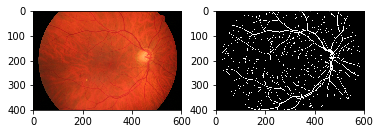

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
plt.imshow(np.transpose(data_set[31]['image'], (1, 2, 0)))
ax2 = fig.add_subplot(2,2,2)
plt.imshow(data_set[31]['mask'][0],cmap='gray')

In [195]:
class extractnet(nn.Module):
    
    def __init__(self):
        super(extractnet, self).__init__()
        # 600 * 400 * 3 -> 600*400*4
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5, padding=2)
        # 600*400*4 -> 600*400*8
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5, padding=2)
        # 600*400*8 -> 600*400*1
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=5, padding=2)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 600*400)
        x = torch.sigmoid(x)
        return x

In [196]:
m = extractnet()

In [197]:
epochs = 10
crit = nn.MultiLabelSoftMarginLoss()
opt = optim.SGD(m.parameters(), lr=1.)

In [198]:
for t, i in enumerate(range(epochs)):
    train_loss = 0.0
    m.train()
    for data in data_loader:
        data,y = data['image'],data['mask']
        if use_cuda:
            data, y = data.cuda(), y.cuda()
        opt.zero_grad()
        y_pred = m(data)
        y = y.view(-1, 600*400)
        loss = crit(y_pred,y)
        loss.backward()
        opt.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(data_loader.dataset)    
    print(t, train_loss)

0 0.9439281476868524
1 0.9438426931699117
2 0.9438064813613891
3 0.9438266648186577
4 0.9438509874873691
5 0.9438184817632039
6 0.9438162485758463
7 0.9438304993841383
8 0.943813157081604
9 0.9438294238514371


In [111]:
a = data_set[0]['image']

In [112]:
a = a.unsqueeze(0)

In [113]:
p = m(a)

In [114]:
p.shape

torch.Size([1, 240000])

In [115]:
p = p.view(400,600)
p.shape

torch.Size([400, 600])

In [117]:
b = data_set[0]['mask'][0]
f = (b-p)
f
print(f.shape)

torch.Size([400, 600])


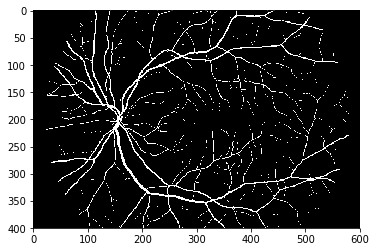

In [118]:
plt.imshow(f.detach().numpy(),cmap='gray')

#### Testing different loss functions

In [159]:
labels = torch.Tensor([[1.,0.,0.],[0.,1.,0.]])


In [162]:
out = torch.autograd.Variable(torch.Tensor([[0.6,0.5,0.5],[0.5,0.5,0.5]]), requires_grad=True)
crit = nn.MultiLabelSoftMarginLoss()

In [194]:
loss = crit(out,labels)
loss.backward()
print(loss.item())
out = torch.autograd.Variable(out - 0.1*out.grad, requires_grad=True)
print(out, loss)

0.13988085091114044
tensor([[ 2.2702, -2.0505, -2.0505],
        [-2.0505,  2.2461, -2.0505]], requires_grad=True) tensor(0.1399, grad_fn=<BinaryCrossEntropyBackward>)
